In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
plt.rcParams['figure.figsize'] = [20, 20] # Set Matplotlib size

# 1. Explore the data

## 1.1 Label Distribution

In [3]:
labels_df = pd.read_csv('labels/labels.csv',header=0)

In [4]:
labels_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [5]:
labels_df['bookingID'].value_counts().head(25)

1391569403991    2
154618822837     2
481036337234     2
919123001348     2
1511828488211    2
970662608932     2
1649267441751    2
515396075694     2
695784702084     2
403726925929     2
1632087572573    2
13               2
395136991308     2
1279900254294    2
1408749273124    2
455266533495     2
1348619731077    2
223338299461     2
901943132350     1
231928234067     1
858993459281     1
1005022347345    1
798863917147     1
1683627180101    1
206158430291     1
Name: bookingID, dtype: int64

We have duplicate rows. Let's see how the duplicate rows are labelled.

In [6]:
labels_df[labels_df['bookingID']==1632087572573]

,bookingID,label
1059,1632087572573,1
14432,1632087572573,0


In [7]:
labels_df[labels_df['bookingID']==13]

,bookingID,label
12463,13,0
12602,13,1


The duplicate IDs have different labels, as we have no way to differentiate which is correct so we drop all of them. These would be 17 IDs out of ~20,000.

In [8]:
labels_df.drop_duplicates(subset=['bookingID'], keep=False, inplace=True)

In [9]:
labels_df['label'].value_counts()

0    14999
1     4983
Name: label, dtype: int64

## 1.2 Features Distribution

In [9]:
feat_df = pd.read_csv('features/features.csv',header=0)

In [10]:
feat_df.shape

(16135561, 11)

In [11]:
feat_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021BE47FD160>,
      dtype=object)

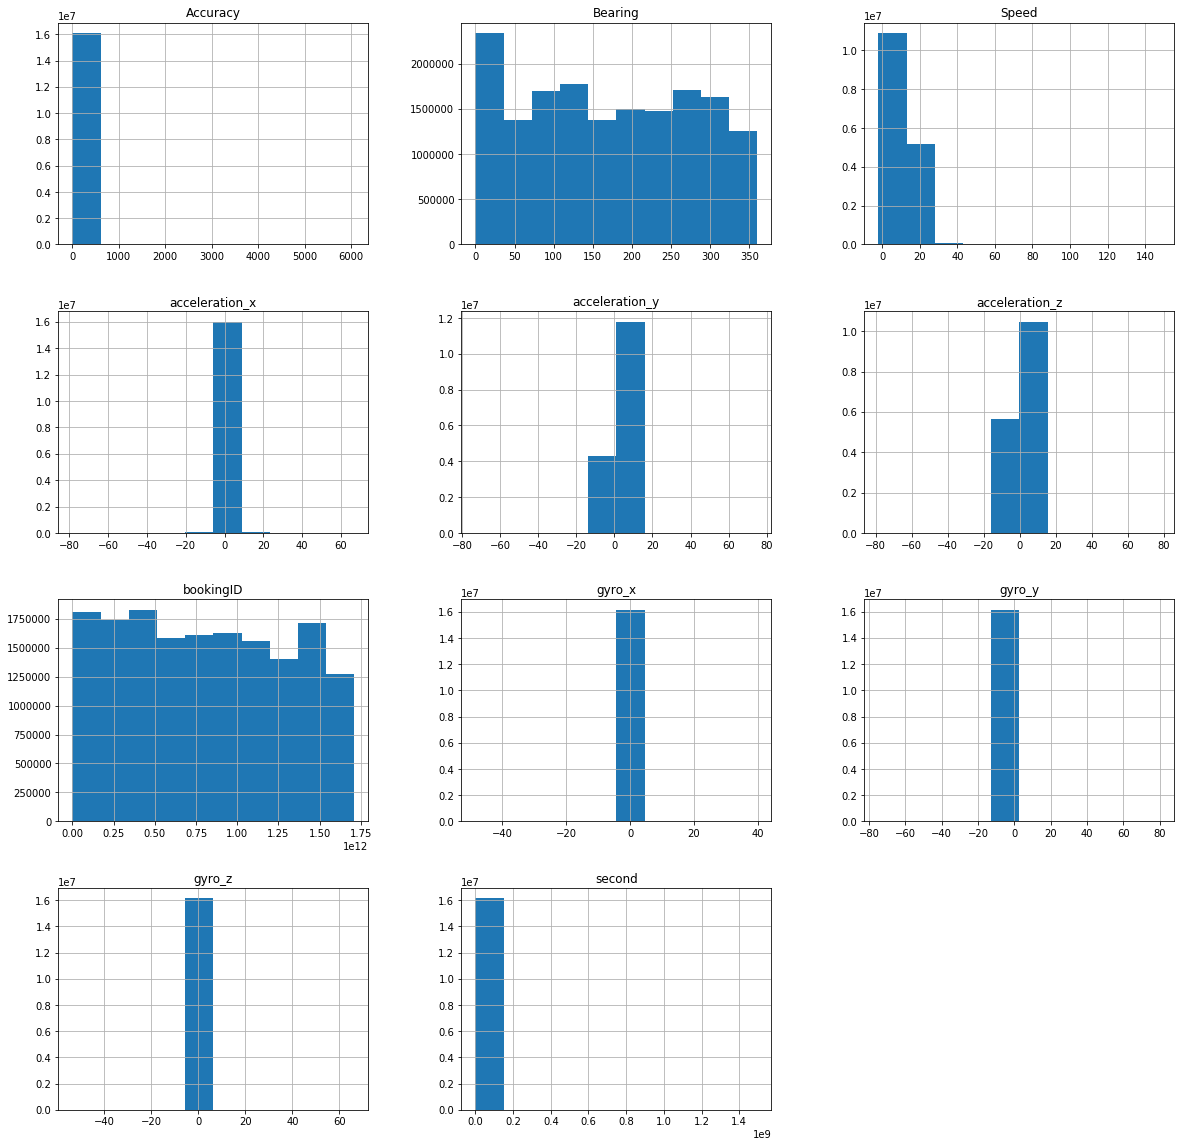

In [12]:
feat_df.hist()

First observations:

* Seconds has a very wide range, there might be some erroneous data
* Speed seems to be very large as well (30 m/s = 108 km/h)

In [13]:
max(feat_df['second'])

1495796757.0

In [14]:
max(feat_df['Speed'])

148.01863

### 1.1.1 Check Seconds variable

Try seeing how many exceed 1e4 (which is 2h 40 min). If they are the same, then we can try cleaning the data by discarding those which exceed

In [15]:
np.sum(feat_df['second']>1e4), np.sum(feat_df['second']>1e5), np.sum(feat_df['second']>1e6)

(82, 82, 82)

In [16]:
feat_df[feat_df['second']>1e4].head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
88251,858993459333,33.727,0.0,-0.507571,9.758766,1.350330,-0.055894,0.140804,0.113315,619315371.0,-1.0
91569,1460288880770,5.994,0.0,-0.114922,9.270349,0.804452,-0.202807,-0.043982,-0.012217,619316528.0,-1.0
150076,1460288880770,5.297,0.0,0.651223,9.385271,1.455675,0.106291,-0.467923,-0.046426,619316508.0,-1.0
233462,858993459333,16.491,0.0,0.488417,9.806650,-0.402226,-0.039706,0.034514,0.038790,619315480.0,-1.0
267319,858993459333,25.836,0.0,1.005565,9.241618,0.411803,-0.176540,-0.076358,-0.007330,619315692.0,-1.0


We are quite sure that these rows have issues with the seconds variable. As we want to construct a time series, we discard these rows as we are unsure where they will be in the sequence.

In [17]:
feat_df = feat_df[feat_df['second']<1e4]

### 1.1.2 Check Speed

In [18]:
feat_df[feat_df['Speed']>50]

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1411481,738734374968,22.512,247.00000,-2.307648,9.837494,1.906753,-0.242294,0.635406,-0.332550,639.0,50.550000
6864727,1297080123464,48.000,293.00000,-0.193930,9.691729,0.761356,0.100182,-0.076969,-0.057421,634.0,88.037254
9137029,953482739877,32.000,307.00000,0.622511,9.380769,-0.418998,0.113717,0.003925,-0.032686,819.0,56.698967
10476836,1297080123464,12.000,157.00000,-0.694319,9.174581,1.282095,0.130725,-0.147829,-0.047647,633.0,72.456825
15324095,317827580025,32.000,285.92395,0.342371,9.309854,-0.204704,0.031958,-0.111853,-0.008522,271.0,148.018630


In [19]:
feat_df.query('bookingID == 317827580025 & second > 265').sort_values('second').head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
4734257,317827580025,32.0,116.034874,2.428918,10.206482,0.746991,0.003196,-0.057524,-0.003196,270.0,5.033003
15324095,317827580025,32.0,285.923950,0.342371,9.309854,-0.204704,0.031958,-0.111853,-0.008522,271.0,148.018630
13619635,317827580025,48.0,232.346970,0.495600,10.126276,0.011971,-0.009587,-0.082025,-0.013848,274.0,29.348158
4308451,317827580025,32.0,211.122500,0.847547,10.228029,-0.542287,0.014914,-0.044741,0.030893,275.0,17.285380
9251893,317827580025,32.0,233.130650,1.124078,9.024943,-1.625663,-0.039415,-0.039415,0.036219,276.0,11.056324


In [20]:
feat_df.query('bookingID == 738734374968 & second > 635').sort_values('second').head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
14477106,738734374968,64.319,0.0,-1.765671,9.034698,1.674652,-0.213257,0.611313,-0.343475,637.0,-1.00
1411481,738734374968,22.512,247.0,-2.307648,9.837494,1.906753,-0.242294,0.635406,-0.332550,639.0,50.55
9841796,738734374968,18.224,260.0,-2.391983,9.725021,3.860489,-0.238235,0.613678,-0.311447,640.0,48.41
2311799,738734374968,16.079,259.0,-2.880722,9.339188,2.087402,-0.227478,0.647766,-0.360519,641.0,43.10
14471862,738734374968,16.079,258.0,-2.448212,9.561127,2.171158,-0.260849,0.635391,-0.326004,642.0,38.76


In [21]:
feat_df.query('bookingID == 1297080123464 & second > 630').sort_values('second').head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
15613351,1297080123464,22.731,247.0,-0.392649,9.923966,-0.022745,0.024435,-0.109956,-0.031765,632.0,3.711382
10476836,1297080123464,12.000,157.0,-0.694319,9.174581,1.282095,0.130725,-0.147829,-0.047647,633.0,72.456825
6864727,1297080123464,48.000,293.0,-0.193930,9.691729,0.761356,0.100182,-0.076969,-0.057421,634.0,88.037254
2036700,1297080123464,24.000,231.0,-0.284910,9.706094,0.624887,-0.003665,-0.064752,-0.040317,636.0,32.417366
5740432,1297080123464,16.000,254.0,-0.724246,9.404425,0.672771,-0.051313,-0.043982,-0.019548,637.0,15.001080


In [22]:
feat_df.query('bookingID == 953482739877& second > 790').sort_values('second').head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
2145810,953482739877,800.0,0.0,0.172388,10.498895,0.945739,-0.165449,0.129764,-0.032075,795.0,-1.000000
9137029,953482739877,32.0,307.0,0.622511,9.380769,-0.418998,0.113717,0.003925,-0.032686,819.0,56.698967
2608104,953482739877,16.0,307.0,-0.339987,10.599455,1.678387,-0.050606,0.018586,-0.053456,820.0,0.000000
4280592,953482739877,16.0,0.0,-0.464489,8.753469,-0.375901,-0.101919,-0.022342,0.000911,821.0,-1.000000
6264233,953482739877,16.0,0.0,-1.980065,8.315316,0.878699,-0.487375,-0.328385,0.074826,822.0,-1.000000


These speed values seem wrong, but unsure if we can discard. Try keeping first.

In [23]:
feat_df['bookingID'].value_counts()

438086664371     7561
1374389534819    4499
34359738469      4302
1108101562533    3925
747324309632     3674
1486058684448    3611
893353197656     3486
1211180777592    3206
1365799600208    3195
120259084461     3172
412316860458     3061
1116691497104    3055
1262720385148    3026
515396075652     2996
1194000908355    2981
953482739722     2929
695784702068     2917
1116691497088    2909
283467841668     2893
77309411460      2868
841813590038     2837
1709396983933    2835
841813590125     2828
841813590042     2815
1700807049324    2790
1065151889429    2788
1125281431586    2774
1159641169935    2755
670014898333     2712
1211180777501    2706
                 ... 
1589137899664     120
575525617679      120
1288490188981     120
515396075679      120
60129542207       120
1348619730958     120
764504178845      120
309237645388      120
25769803813       120
343597383756      120
1228360646706     120
103079215187      120
149               120
558345748556      120
8504035247

Each trip has between 120 to 7000 records. Let's see how the trips look like.

In [24]:
def plot_trip(df, bookingID):
    df[df['bookingID'] == bookingID].sort_values('second').plot(x='second', subplots=True, sharex=True, figsize=(16,16))
    plt.show()

In [25]:
def plot_random_trip(df, labels_df, label):
    id_ = labels_df[labels_df['label']==label].sample().iloc[0]['bookingID']
    print('Plotting for trip ' + str(id_))
    plot_trip(df, id_)

Example of how a trip with label 1 looks like:

Plotting for trip 1228360646812


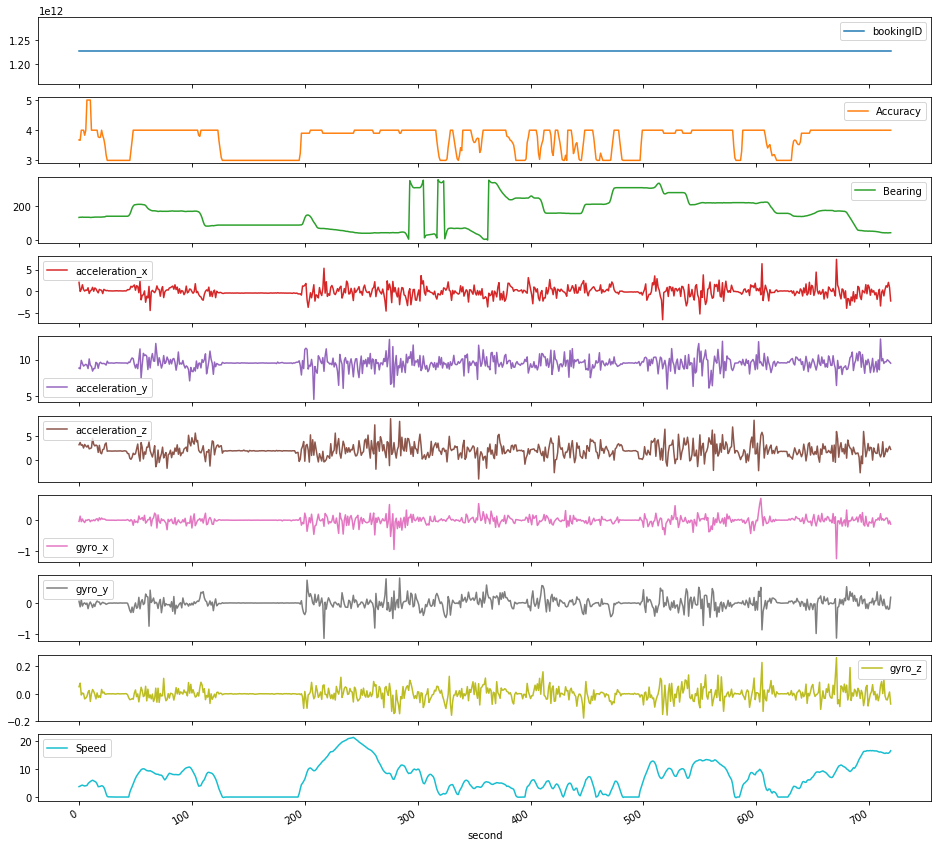

In [26]:
plot_random_trip(feat_df, labels_df, 1)

Example of how a trip with label 0 looks like:

Plotting for trip 833223655501


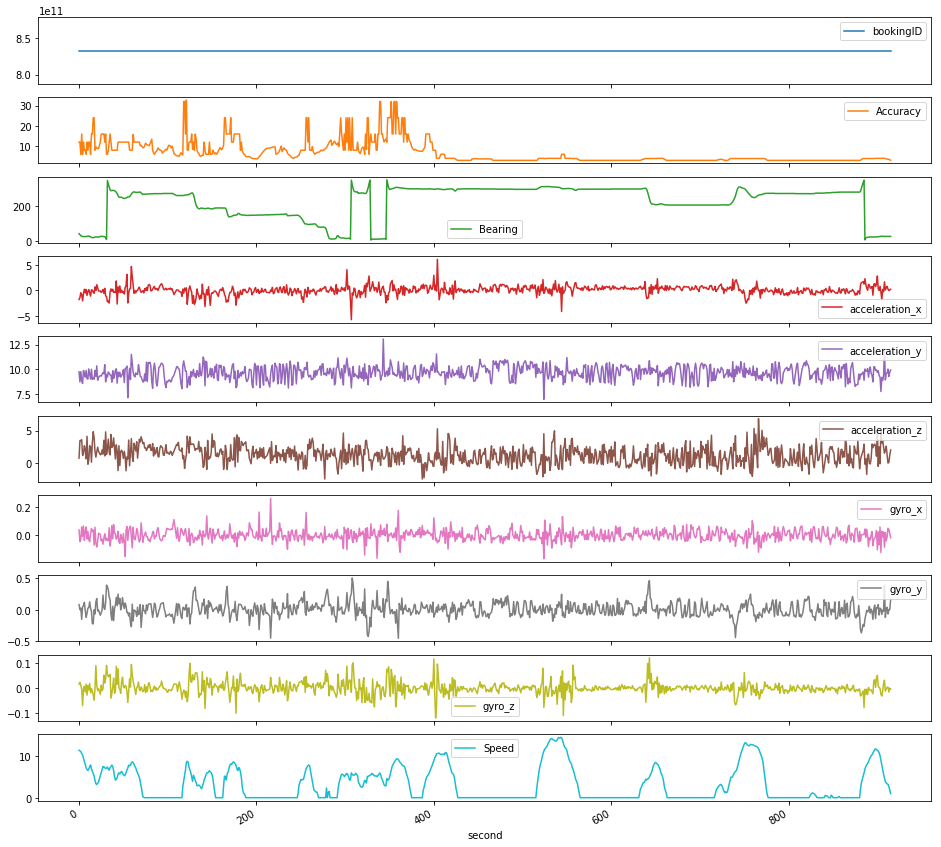

In [27]:
plot_random_trip(feat_df, labels_df, 0)

Some observations in general:
* Acceleration y is usually either positive or negative and centered around 9.8 (which is the force of gravity). It seems logical to covert this to absolute values and subtract 9.8.
* While most of the observations happen every second, there are noticeable gaps.
* Bearing and Speed are subject to GPS accuracy, which is affected by tunnels/flyovers/buildings, so these are less reliable.

Transform Acceleration y first:

In [28]:
feat_df['acceleration_y'] = abs(feat_df['acceleration_y']) - 9.8

# 2. Generating new features

Try:
* Magnitudes of xy, xz, yz combinations
* Angles
* Moving Averages
* Difference with Moving Average

Due to the size of the features, this needs to be done in a smart way:
* Extract each bookingID
* Add features
* Use tsfresh
* Add to new df

## 2.1 Combination of xy, xz, yz, xyz acceleration and gyro

In [32]:
def calc_xyz_feats(df):
    df['acceleration_xy'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2)
    df['acceleration_xz'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_z']**2)
    df['acceleration_yz'] = np.sqrt(df['acceleration_y']**2 + df['acceleration_z']**2)
    df['acceleration_xyz'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2 + df['acceleration_z']**2)
    df['gyro_xy'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2)
    df['gyro_xz'] = np.sqrt(df['gyro_x']**2 + df['gyro_z']**2)
    df['gyro_yz'] = np.sqrt(df['gyro_y']**2 + df['gyro_z']**2)
    df['gyro_xyz'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

## 2.2 Acceleration and Gyroscope Angles

In [33]:
def calc_angle_feats(df):
    df['acc_xy_angle'] = np.arctan(df['acceleration_y']/df['acceleration_x'])
    df['acc_xz_angle'] = np.arctan(df['acceleration_z']/df['acceleration_x'])
    df['acc_yz_angle'] = np.arctan(df['acceleration_z']/df['acceleration_y'])
    df['acc_xyz_angle'] = np.arccos(df['acceleration_z']/df['acceleration_xyz'])
    df['gyro_xy_angle'] = np.arctan(df['gyro_y']/df['gyro_x'])
    df['gyro_yz_angle'] = np.arctan(df['gyro_z']/df['gyro_y'])
    df['gyro_xz_angle'] = np.arctan(df['gyro_z']/df['gyro_x'])
    df['gyro_xyz_angle'] = np.arccos(df['gyro_z']/df['gyro_xyz'])

## 2.3 Delta Features

In [34]:
def calc_delta_feats(df):
    df['delta_acc_x'] = df['acceleration_x'] - df['acceleration_x'].shift(1)
    df['delta_acc_y'] = df['acceleration_y'] - df['acceleration_y'].shift(1)
    df['delta_acc_z'] = df['acceleration_z'] - df['acceleration_z'].shift(1)
    df['delta_acc_xy'] = df['acceleration_xy'] - df['acceleration_xy'].shift(1)
    df['delta_acc_xz'] = df['acceleration_xz'] - df['acceleration_xz'].shift(1)
    df['delta_acc_yz'] = df['acceleration_yz'] - df['acceleration_yz'].shift(1)
    df['delta_acc_xyz'] = df['acceleration_xyz'] - df['acceleration_xyz'].shift(1)

    df['delta_gyro_x'] = df['gyro_x'] - df['gyro_x'].shift(1)
    df['delta_gyro_y'] = df['gyro_y'] - df['gyro_y'].shift(1)
    df['delta_gyro_z'] = df['gyro_z'] - df['gyro_z'].shift(1)
    df['delta_gyro_xy'] = df['gyro_xy'] - df['gyro_xy'].shift(1)
    df['delta_gyro_xz'] = df['gyro_xz'] - df['gyro_xz'].shift(1)
    df['delta_gyro_yz'] = df['gyro_yz'] - df['gyro_yz'].shift(1)
    df['delta_gyro_xyz'] = df['gyro_xyz'] - df['gyro_xyz'].shift(1)

    df['delta_acc_xy_angle'] = df['acc_xy_angle'] - df['acc_xy_angle'].shift(1)
    df['delta_acc_xz_angle'] = df['acc_xz_angle'] - df['acc_xz_angle'].shift(1)
    df['delta_acc_yz_angle'] = df['acc_yz_angle'] - df['acc_yz_angle'].shift(1)
    df['delta_acc_xyz_angle'] = df['acc_xyz_angle'] - df['acc_xyz_angle'].shift(1)

    df['delta_gyro_xy_angle'] = df['gyro_xy_angle'] - df['gyro_xy_angle'].shift(1)
    df['delta_gyro_xz_angle'] = df['gyro_xz_angle'] - df['gyro_xz_angle'].shift(1)
    df['delta_gyro_yz_angle'] = df['gyro_yz_angle'] - df['gyro_yz_angle'].shift(1)
    df['delta_gyro_xyz_angle'] = df['gyro_xyz_angle'] - df['gyro_xyz_angle'].shift(1)


# 3 Time Series Feature Extraction

## 3.1 Using tsfresh

In [33]:
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction.settings import EfficientFCParameters

In [34]:
import logging
logger = logging.getLogger() 
logger.setLevel(logging.CRITICAL)

In [35]:
min_ext_feat_df = pd.DataFrame()

for id_ in labels_df['bookingID']:
    cur_id_df = feat_df[feat_df['bookingID']==id_].sort_values('second')
    
    calc_xyz_feats(cur_id_df)
    calc_angle_feats(cur_id_df)
    calc_delta_feats(cur_id_df)
    
    cur_id_df.fillna(0, inplace=True)
    
    cur_id_ext_df = extract_features(cur_id_df, column_id="bookingID", column_sort="second",n_jobs=2, default_fc_parameters=MinimalFCParameters())
    
    min_ext_feat_df = min_ext_feat_df.append(cur_id_ext_df)

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 704.34it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 785.11it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 832.63it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 615.82it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 699.21it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 658.61it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 615.89it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 689.25it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 1028.80it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 655.46it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 1398.33it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 1144.02it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 746.05it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 859.61it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 875.88it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 593.87it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 498.67it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 1230.76it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 543.98it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 517.82it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 557.71it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 485.29it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 412.11it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 420.72it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 446.85it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 395.25it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 385.74it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 211.97it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 329.97it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 300.07it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 308.39it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 312.23it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 301.06it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 286.57it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 285.54it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 257.92it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 251.79it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 274.59it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 278.34it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 238.35it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 225.72it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 283.78it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 216.06it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 230.63it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 221.73it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 213.52it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 197.58it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 194.50it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 199.50it/s]


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 214.28it/s]


Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 3.2 Manual Feature Engineering

In [40]:
man_ext_feat_df = pd.DataFrame()

for id_ in labels_df['bookingID']:
    cur_id_df = feat_df[feat_df['bookingID']==id_].sort_values('second')
    
    calc_xyz_feats(cur_id_df)
    calc_angle_feats(cur_id_df)
    calc_delta_feats(cur_id_df)
    
    cur_id_df.fillna(0, inplace=True)
    
    cur_id_ext_df = pd.DataFrame(data={
        'acu_gt_20': int(cur_id_df['Accuracy'].max() > 20),
        'acu_gt_30': int(cur_id_df['Accuracy'].max() > 30),
        'acu_gt_40': int(cur_id_df['Accuracy'].max() > 40),
        'acc_x_gt_1': int(cur_id_df['acceleration_x'].abs().max() > 1),
        'acc_x_gt_2': int(cur_id_df['acceleration_x'].abs().max() > 2),
        'acc_x_gt_3': int(cur_id_df['acceleration_x'].abs().max() > 3),
        'acc_x_gt_5': int(cur_id_df['acceleration_x'].abs().max() > 5),
        'acc_y_gt_1': int(cur_id_df['acceleration_y'].abs().max() > 1),
        'acc_y_gt_2': int(cur_id_df['acceleration_y'].abs().max() > 2),
        'acc_y_gt_3': int(cur_id_df['acceleration_y'].abs().max() > 3),
        'acc_y_gt_5': int(cur_id_df['acceleration_y'].abs().max() > 5),
        'acc_z_gt_1': int(cur_id_df['acceleration_z'].abs().max() > 1),
        'acc_z_gt_2': int(cur_id_df['acceleration_z'].abs().max() > 2),
        'acc_z_gt_3': int(cur_id_df['acceleration_z'].abs().max() > 3),
        'acc_z_gt_5': int(cur_id_df['acceleration_z'].abs().max() > 5),
        'acc_xy_gt_1': int(cur_id_df['acceleration_xy'].abs().max() > 1),
        'acc_xy_gt_2': int(cur_id_df['acceleration_xy'].abs().max() > 2),
        'acc_xy_gt_3': int(cur_id_df['acceleration_xy'].abs().max() > 3),
        'acc_xy_gt_5': int(cur_id_df['acceleration_xy'].abs().max() > 5),
        'acc_xy_gt_8': int(cur_id_df['acceleration_xy'].abs().max() > 8),
        'acc_xz_gt_1': int(cur_id_df['acceleration_xz'].abs().max() > 1),
        'acc_xz_gt_2': int(cur_id_df['acceleration_xz'].abs().max() > 2),
        'acc_xz_gt_3': int(cur_id_df['acceleration_xz'].abs().max() > 3),
        'acc_xz_gt_5': int(cur_id_df['acceleration_xz'].abs().max() > 5),
        'acc_xz_gt_8': int(cur_id_df['acceleration_xz'].abs().max() > 8),
        'acc_yz_gt_1': int(cur_id_df['acceleration_yz'].abs().max() > 1),
        'acc_yz_gt_2': int(cur_id_df['acceleration_yz'].abs().max() > 2),
        'acc_yz_gt_3': int(cur_id_df['acceleration_yz'].abs().max() > 3),
        'acc_yz_gt_5': int(cur_id_df['acceleration_yz'].abs().max() > 5),
        'acc_yz_gt_8': int(cur_id_df['acceleration_yz'].abs().max() > 8),
        'acc_xyz_gt_1': int(cur_id_df['acceleration_xyz'].abs().max() > 1),
        'acc_xyz_gt_2': int(cur_id_df['acceleration_xyz'].abs().max() > 2),
        'acc_xyz_gt_3': int(cur_id_df['acceleration_xyz'].abs().max() > 3),
        'acc_xyz_gt_5': int(cur_id_df['acceleration_xyz'].abs().max() > 5),
        'acc_xyz_gt_8': int(cur_id_df['acceleration_xyz'].abs().max() > 8),
        'delta_acc_x_gt_1': int(cur_id_df['delta_acc_x'].abs().max() > 1),
        'delta_acc_x_gt_2': int(cur_id_df['delta_acc_x'].abs().max() > 2),
        'delta_acc_x_gt_3': int(cur_id_df['delta_acc_x'].abs().max() > 3),
        'delta_acc_x_gt_5': int(cur_id_df['delta_acc_x'].abs().max() > 5),
        'delta_acc_y_gt_1': int(cur_id_df['delta_acc_y'].abs().max() > 1),
        'delta_acc_y_gt_2': int(cur_id_df['delta_acc_y'].abs().max() > 2),
        'delta_acc_y_gt_3': int(cur_id_df['delta_acc_y'].abs().max() > 3),
        'delta_acc_y_gt_5': int(cur_id_df['delta_acc_y'].abs().max() > 5),
        'delta_acc_z_gt_1': int(cur_id_df['delta_acc_z'].abs().max() > 1),
        'delta_acc_z_gt_2': int(cur_id_df['delta_acc_z'].abs().max() > 2),
        'delta_acc_z_gt_3': int(cur_id_df['delta_acc_z'].abs().max() > 3),
        'delta_acc_z_gt_5': int(cur_id_df['delta_acc_z'].abs().max() > 5),
        'delta_acc_xy_gt_1': int(cur_id_df['delta_acc_xy'].abs().max() > 1),
        'delta_acc_xy_gt_2': int(cur_id_df['delta_acc_xy'].abs().max() > 2),
        'delta_acc_xy_gt_3': int(cur_id_df['delta_acc_xy'].abs().max() > 3),
        'delta_acc_xy_gt_5': int(cur_id_df['delta_acc_xy'].abs().max() > 5),
        'delta_acc_xz_gt_1': int(cur_id_df['delta_acc_xz'].abs().max() > 1),
        'delta_acc_xz_gt_2': int(cur_id_df['delta_acc_xz'].abs().max() > 2),
        'delta_acc_xz_gt_3': int(cur_id_df['delta_acc_xz'].abs().max() > 3),
        'delta_acc_xz_gt_5': int(cur_id_df['delta_acc_xz'].abs().max() > 5),
        'delta_acc_yz_gt_1': int(cur_id_df['delta_acc_yz'].abs().max() > 1),
        'delta_acc_yz_gt_2': int(cur_id_df['delta_acc_yz'].abs().max() > 2),
        'delta_acc_yz_gt_3': int(cur_id_df['delta_acc_yz'].abs().max() > 3),
        'delta_acc_yz_gt_5': int(cur_id_df['delta_acc_yz'].abs().max() > 5),
        'delta_acc_xyz_gt_1': int(cur_id_df['delta_acc_xyz'].abs().max() > 1),
        'delta_acc_xyz_gt_2': int(cur_id_df['delta_acc_xyz'].abs().max() > 2),
        'delta_acc_xyz_gt_3': int(cur_id_df['delta_acc_xyz'].abs().max() > 3),
        'delta_acc_xyz_gt_5': int(cur_id_df['delta_acc_xyz'].abs().max() > 5),
        'delta_acc_xy_angle_gt_1': int(cur_id_df['delta_acc_xy_angle'].abs().max() > 1),
        'delta_acc_xy_angle_gt_2': int(cur_id_df['delta_acc_xy_angle'].abs().max() > 2),
        'delta_acc_xz_angle_gt_1': int(cur_id_df['delta_acc_xz_angle'].abs().max() > 1),
        'delta_acc_xz_angle_gt_2': int(cur_id_df['delta_acc_xz_angle'].abs().max() > 2),
        'delta_acc_yz_angle_gt_1': int(cur_id_df['delta_acc_yz_angle'].abs().max() > 1),
        'delta_acc_yz_angle_gt_2': int(cur_id_df['delta_acc_yz_angle'].abs().max() > 2),
        'delta_acc_xyz_angle_gt_1': int(cur_id_df['delta_acc_xyz_angle'].abs().max() > 1),
        'delta_acc_xyz_angle_gt_2': int(cur_id_df['delta_acc_xyz_angle'].abs().max() > 2)      
    },index=[id_])
    
    man_ext_feat_df = man_ext_feat_df.append(cur_id_ext_df)

In [41]:
man_ext_feat_df.shape

(19982, 71)

In [49]:
man_ext_feat_df.sort_index(inplace=True,kind='mergesort')

In [50]:
labels_df.sort_values(by='bookingID',inplace=True,kind='mergesort')

# 4 Establish a baseline

# 4.1 Naive Bayes

Naive Bayes is fast and straightforward, with high interpretability.

In [62]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [98]:
gnb_clf = GaussianNB(priors=None, var_smoothing=1e-09)

In [99]:
gnb_param = {'var_smoothing':[1e-09, 1e-07]}

In [102]:
opt_gnb = GridSearchCV(
    estimator = gnb_clf,
    param_grid=gnb_param,
    cv=5,
    scoring='roc_auc',
    iid=False,
    verbose=20,
    n_jobs=2,
    refit=False)

In [121]:
opt_gnb.fit(ext_feat_df, labels_df['label'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:   15.5s
[Parallel(n_jobs=2)]: Done   8 out of  10 | elapsed:   15.5s remaining:    3.8s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   16.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'var_smoothing': [1e-09, 1e-07]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [126]:
opt_gnb.best_score_

0.6699121421749268

We use Bernoulli NB for the manual binary features

In [64]:
bnb_clf = BernoulliNB(alpha=1.0, binarize=0.5, fit_prior=True, class_prior=None)

In [79]:
bnb_param = {'alpha':[1,10,100]}

In [80]:
opt_bnb = GridSearchCV(
    estimator = bnb_clf,
    param_grid=bnb_param,
    cv=5,
    scoring='roc_auc',
    iid=False,
    verbose=20,
    n_jobs=1,
    refit=False)

In [81]:
opt_bnb.fit(man_ext_feat_df, labels_df['label'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=1 .........................................................
[CV] ................. alpha=1, score=0.574601136743564, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ................ alpha=1, score=0.6089899699097292, total=   0.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................ alpha=1, score=0.6192723169508525, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ................ alpha=1, score=0.6135778112449799, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ................ alpha=1, score=0.6204907994766663, total=   0.0s
[CV] alpha=10 ........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


[CV] ............... alpha=10, score=0.5746178535606821, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.6088742895352726, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.6195544968238047, total=   0.0s
[CV] alpha=10 ........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s


[CV] ............... alpha=10, score=0.6131865796519411, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.6200800199798862, total=   0.0s
[CV] alpha=100 .......................................................
[CV] .............. alpha=100, score=0.5723851554663992, total=   0.0s
[CV] alpha=100 .......................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s


[CV] .............. alpha=100, score=0.6053350050150451, total=   0.0s
[CV] alpha=100 .......................................................
[CV] .............. alpha=100, score=0.6176588097626212, total=   0.0s
[CV] alpha=100 .......................................................
[CV] .............. alpha=100, score=0.6089506358768407, total=   0.0s
[CV] alpha=100 .......................................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s remaining:    0.0s


[CV] .............. alpha=100, score=0.6136568615241225, total=   0.0s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BernoulliNB(alpha=1.0, binarize=0.5, class_prior=None, fit_prior=True),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'alpha': [1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='roc_auc',
       verbose=20)

In [82]:
opt_bnb.best_score_

0.6073864068651584

# 5 Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
gb_clf = GradientBoostingClassifier(loss='deviance', 
                                    learning_rate=0.1, 
                                    n_estimators=100, 
                                    subsample=1.0, 
                                    criterion='friedman_mse')

In [44]:
gb_param = {'learning_rate':[0.05, 0.1],
             'n_estimators':[100, 200]}

In [52]:
opt_gb = GridSearchCV(
    estimator = gb_clf,
    param_grid=gb_param,
    cv=5,
    scoring='roc_auc',
    iid=False,
    verbose=20,
    n_jobs=4,
    refit=False)

In [53]:
opt_gb.fit(man_ext_feat_df, labels_df['label'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done  15 out of  20 | elapsed:   13.2s remaining:    4.4s
[Parallel(n_jobs=4)]: Done  17 out of  20 | elapsed:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [54]:
opt_gb.best_score_

0.6147345653816779

# 6 Deep Learning

In [36]:
import tensorflow as tf

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [38]:
from sklearn.preprocessing import MaxAbsScaler

In [39]:
scaler = MaxAbsScaler()

In [150]:
ext_feat_scaled = scaler.fit_transform(ext_feat_df)

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ext_feat_scaled, labels_df['label'], test_size=0.2, random_state=42)

In [152]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    tf.keras.layers.Dense(500,activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])

In [153]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [154]:
es = EarlyStopping(monitor='val_loss',
                  mode='auto',
                  patience=50,
                  verbose=1,
                  restore_best_weights=True)

In [155]:
model1.fit(X_train, y_train, epochs=500, validation_data=(X_test,y_test), callbacks=[es,])

Train on 15985 samples, validate on 3997 samples
Epoch 1/500
15985/15985==============================] - ETA: 1:53 - loss: 0.6040 - acc: 0.843 - ETA: 11s - loss: 0.6356 - acc: 0.726 - ETA: 7s - loss: 0.6204 - acc: 0.7315 - ETA: 5s - loss: 0.6033 - acc: 0.735 - ETA: 4s - loss: 0.5968 - acc: 0.734 - ETA: 4s - loss: 0.5808 - acc: 0.742 - ETA: 3s - loss: 0.5764 - acc: 0.741 - ETA: 3s - loss: 0.5727 - acc: 0.743 - ETA: 3s - loss: 0.5655 - acc: 0.746 - ETA: 3s - loss: 0.5590 - acc: 0.750 - ETA: 2s - loss: 0.5597 - acc: 0.749 - ETA: 2s - loss: 0.5527 - acc: 0.754 - ETA: 2s - loss: 0.5548 - acc: 0.752 - ETA: 2s - loss: 0.5545 - acc: 0.753 - ETA: 2s - loss: 0.5538 - acc: 0.752 - ETA: 2s - loss: 0.5533 - acc: 0.753 - ETA: 2s - loss: 0.5515 - acc: 0.753 - ETA: 2s - loss: 0.5515 - acc: 0.753 - ETA: 2s - loss: 0.5514 - acc: 0.753 - ETA: 1s - loss: 0.5460 - acc: 0.756 - ETA: 1s - loss: 0.5439 - acc: 0.758 - ETA: 1s - loss: 0.5432 - acc: 0.758 - ETA: 1s - loss: 0.5414 - acc: 0.759 - ETA: 1s - loss: 

15985/15985==============================] - ETA: 2s - loss: 0.5724 - acc: 0.718 - ETA: 2s - loss: 0.4942 - acc: 0.784 - ETA: 2s - loss: 0.4888 - acc: 0.779 - ETA: 2s - loss: 0.4927 - acc: 0.780 - ETA: 2s - loss: 0.5100 - acc: 0.768 - ETA: 2s - loss: 0.5110 - acc: 0.764 - ETA: 2s - loss: 0.5111 - acc: 0.765 - ETA: 2s - loss: 0.5169 - acc: 0.759 - ETA: 2s - loss: 0.5219 - acc: 0.757 - ETA: 2s - loss: 0.5222 - acc: 0.758 - ETA: 1s - loss: 0.5226 - acc: 0.757 - ETA: 1s - loss: 0.5192 - acc: 0.759 - ETA: 1s - loss: 0.5171 - acc: 0.762 - ETA: 1s - loss: 0.5152 - acc: 0.764 - ETA: 1s - loss: 0.5125 - acc: 0.767 - ETA: 1s - loss: 0.5134 - acc: 0.767 - ETA: 1s - loss: 0.5098 - acc: 0.769 - ETA: 1s - loss: 0.5116 - acc: 0.768 - ETA: 1s - loss: 0.5078 - acc: 0.771 - ETA: 1s - loss: 0.5097 - acc: 0.771 - ETA: 1s - loss: 0.5084 - acc: 0.772 - ETA: 1s - loss: 0.5079 - acc: 0.772 - ETA: 1s - loss: 0.5081 - acc: 0.772 - ETA: 1s - loss: 0.5069 - acc: 0.773 - ETA: 1s - loss: 0.5077 - acc: 0.773 - ETA: 

15985/15985==============================] - ETA: 2s - loss: 0.4786 - acc: 0.750 - ETA: 2s - loss: 0.4833 - acc: 0.796 - ETA: 2s - loss: 0.5027 - acc: 0.781 - ETA: 2s - loss: 0.5011 - acc: 0.776 - ETA: 2s - loss: 0.4913 - acc: 0.782 - ETA: 2s - loss: 0.4938 - acc: 0.781 - ETA: 2s - loss: 0.4923 - acc: 0.783 - ETA: 2s - loss: 0.4933 - acc: 0.782 - ETA: 2s - loss: 0.4954 - acc: 0.782 - ETA: 2s - loss: 0.4963 - acc: 0.781 - ETA: 2s - loss: 0.4978 - acc: 0.781 - ETA: 1s - loss: 0.4992 - acc: 0.780 - ETA: 1s - loss: 0.4958 - acc: 0.782 - ETA: 1s - loss: 0.4945 - acc: 0.783 - ETA: 1s - loss: 0.4964 - acc: 0.781 - ETA: 1s - loss: 0.4927 - acc: 0.784 - ETA: 1s - loss: 0.4939 - acc: 0.783 - ETA: 1s - loss: 0.4934 - acc: 0.783 - ETA: 1s - loss: 0.4932 - acc: 0.782 - ETA: 1s - loss: 0.4925 - acc: 0.783 - ETA: 1s - loss: 0.4918 - acc: 0.784 - ETA: 1s - loss: 0.4908 - acc: 0.785 - ETA: 1s - loss: 0.4897 - acc: 0.785 - ETA: 1s - loss: 0.4883 - acc: 0.786 - ETA: 1s - loss: 0.4898 - acc: 0.784 - ETA: 

15985/15985==============================] - ETA: 2s - loss: 0.7684 - acc: 0.656 - ETA: 2s - loss: 0.5070 - acc: 0.767 - ETA: 2s - loss: 0.4698 - acc: 0.794 - ETA: 2s - loss: 0.4778 - acc: 0.794 - ETA: 2s - loss: 0.4760 - acc: 0.799 - ETA: 2s - loss: 0.4845 - acc: 0.793 - ETA: 2s - loss: 0.4818 - acc: 0.790 - ETA: 2s - loss: 0.4879 - acc: 0.785 - ETA: 2s - loss: 0.4888 - acc: 0.784 - ETA: 2s - loss: 0.4917 - acc: 0.780 - ETA: 1s - loss: 0.4947 - acc: 0.777 - ETA: 1s - loss: 0.4945 - acc: 0.778 - ETA: 1s - loss: 0.4913 - acc: 0.780 - ETA: 1s - loss: 0.4902 - acc: 0.781 - ETA: 1s - loss: 0.4912 - acc: 0.779 - ETA: 1s - loss: 0.4916 - acc: 0.778 - ETA: 1s - loss: 0.4929 - acc: 0.776 - ETA: 1s - loss: 0.4916 - acc: 0.775 - ETA: 1s - loss: 0.4893 - acc: 0.778 - ETA: 1s - loss: 0.4908 - acc: 0.777 - ETA: 1s - loss: 0.4912 - acc: 0.776 - ETA: 1s - loss: 0.4927 - acc: 0.776 - ETA: 1s - loss: 0.4928 - acc: 0.776 - ETA: 1s - loss: 0.4943 - acc: 0.776 - ETA: 1s - loss: 0.4907 - acc: 0.779 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.4551 - acc: 0.750 - ETA: 2s - loss: 0.4429 - acc: 0.799 - ETA: 2s - loss: 0.4580 - acc: 0.796 - ETA: 2s - loss: 0.4587 - acc: 0.796 - ETA: 2s - loss: 0.4736 - acc: 0.779 - ETA: 2s - loss: 0.4744 - acc: 0.779 - ETA: 2s - loss: 0.4778 - acc: 0.777 - ETA: 2s - loss: 0.4790 - acc: 0.779 - ETA: 2s - loss: 0.4785 - acc: 0.780 - ETA: 1s - loss: 0.4811 - acc: 0.780 - ETA: 1s - loss: 0.4813 - acc: 0.781 - ETA: 1s - loss: 0.4788 - acc: 0.783 - ETA: 1s - loss: 0.4790 - acc: 0.783 - ETA: 1s - loss: 0.4761 - acc: 0.784 - ETA: 1s - loss: 0.4759 - acc: 0.784 - ETA: 1s - loss: 0.4774 - acc: 0.782 - ETA: 1s - loss: 0.4744 - acc: 0.786 - ETA: 1s - loss: 0.4730 - acc: 0.787 - ETA: 1s - loss: 0.4715 - acc: 0.787 - ETA: 1s - loss: 0.4731 - acc: 0.785 - ETA: 1s - loss: 0.4724 - acc: 0.786 - ETA: 1s - loss: 0.4730 - acc: 0.786 - ETA: 1s - loss: 0.4744 - acc: 0.786 - ETA: 1s - loss: 0.4733 - acc: 0.788 - ETA: 1s - loss: 0.4752 - acc: 0.786 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.5312 - acc: 0.718 - ETA: 2s - loss: 0.4572 - acc: 0.796 - ETA: 2s - loss: 0.4662 - acc: 0.790 - ETA: 2s - loss: 0.4666 - acc: 0.794 - ETA: 2s - loss: 0.4600 - acc: 0.798 - ETA: 2s - loss: 0.4676 - acc: 0.794 - ETA: 2s - loss: 0.4660 - acc: 0.795 - ETA: 2s - loss: 0.4629 - acc: 0.797 - ETA: 2s - loss: 0.4611 - acc: 0.796 - ETA: 2s - loss: 0.4653 - acc: 0.795 - ETA: 2s - loss: 0.4648 - acc: 0.794 - ETA: 1s - loss: 0.4684 - acc: 0.790 - ETA: 1s - loss: 0.4694 - acc: 0.790 - ETA: 1s - loss: 0.4712 - acc: 0.790 - ETA: 1s - loss: 0.4673 - acc: 0.791 - ETA: 1s - loss: 0.4681 - acc: 0.790 - ETA: 1s - loss: 0.4687 - acc: 0.789 - ETA: 1s - loss: 0.4684 - acc: 0.790 - ETA: 1s - loss: 0.4715 - acc: 0.789 - ETA: 1s - loss: 0.4709 - acc: 0.790 - ETA: 1s - loss: 0.4729 - acc: 0.788 - ETA: 1s - loss: 0.4748 - acc: 0.786 - ETA: 1s - loss: 0.4736 - acc: 0.788 - ETA: 1s - loss: 0.4741 - acc: 0.787 - ETA: 1s - loss: 0.4752 - acc: 0.786 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.4156 - acc: 0.812 - ETA: 2s - loss: 0.4416 - acc: 0.802 - ETA: 2s - loss: 0.4657 - acc: 0.792 - ETA: 2s - loss: 0.4615 - acc: 0.790 - ETA: 2s - loss: 0.4577 - acc: 0.792 - ETA: 2s - loss: 0.4697 - acc: 0.780 - ETA: 2s - loss: 0.4577 - acc: 0.788 - ETA: 2s - loss: 0.4600 - acc: 0.789 - ETA: 2s - loss: 0.4594 - acc: 0.791 - ETA: 1s - loss: 0.4585 - acc: 0.793 - ETA: 1s - loss: 0.4570 - acc: 0.794 - ETA: 1s - loss: 0.4561 - acc: 0.796 - ETA: 1s - loss: 0.4524 - acc: 0.798 - ETA: 1s - loss: 0.4582 - acc: 0.795 - ETA: 1s - loss: 0.4564 - acc: 0.797 - ETA: 1s - loss: 0.4553 - acc: 0.798 - ETA: 1s - loss: 0.4558 - acc: 0.798 - ETA: 1s - loss: 0.4594 - acc: 0.795 - ETA: 1s - loss: 0.4624 - acc: 0.792 - ETA: 1s - loss: 0.4618 - acc: 0.793 - ETA: 1s - loss: 0.4604 - acc: 0.793 - ETA: 1s - loss: 0.4621 - acc: 0.792 - ETA: 1s - loss: 0.4639 - acc: 0.791 - ETA: 1s - loss: 0.4655 - acc: 0.791 - ETA: 1s - loss: 0.4658 - acc: 0.791 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.4342 - acc: 0.875 - ETA: 2s - loss: 0.4850 - acc: 0.795 - ETA: 2s - loss: 0.4703 - acc: 0.787 - ETA: 2s - loss: 0.4767 - acc: 0.785 - ETA: 2s - loss: 0.4735 - acc: 0.783 - ETA: 2s - loss: 0.4633 - acc: 0.791 - ETA: 2s - loss: 0.4585 - acc: 0.794 - ETA: 2s - loss: 0.4508 - acc: 0.797 - ETA: 2s - loss: 0.4469 - acc: 0.799 - ETA: 2s - loss: 0.4474 - acc: 0.800 - ETA: 2s - loss: 0.4494 - acc: 0.800 - ETA: 1s - loss: 0.4477 - acc: 0.803 - ETA: 1s - loss: 0.4507 - acc: 0.800 - ETA: 1s - loss: 0.4500 - acc: 0.799 - ETA: 1s - loss: 0.4492 - acc: 0.799 - ETA: 1s - loss: 0.4507 - acc: 0.797 - ETA: 1s - loss: 0.4526 - acc: 0.796 - ETA: 1s - loss: 0.4516 - acc: 0.798 - ETA: 1s - loss: 0.4533 - acc: 0.796 - ETA: 1s - loss: 0.4553 - acc: 0.794 - ETA: 1s - loss: 0.4542 - acc: 0.795 - ETA: 1s - loss: 0.4544 - acc: 0.795 - ETA: 1s - loss: 0.4530 - acc: 0.796 - ETA: 1s - loss: 0.4527 - acc: 0.796 - ETA: 1s - loss: 0.4528 - acc: 0.796 - ETA: 

In [159]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    tf.keras.layers.Dense(1000,activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1000,activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])

In [160]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Train on 15985 samples, validate on 3997 samples
Epoch 1/500
15985/15985==============================] - ETA: 2:25 - loss: 0.6571 - acc: 0.718 - ETA: 18s - loss: 0.5931 - acc: 0.767 - ETA: 11s - loss: 0.5587 - acc: 0.77 - ETA: 8s - loss: 0.5423 - acc: 0.7788 - ETA: 7s - loss: 0.5338 - acc: 0.781 - ETA: 6s - loss: 0.5443 - acc: 0.774 - ETA: 5s - loss: 0.5495 - acc: 0.768 - ETA: 5s - loss: 0.5429 - acc: 0.772 - ETA: 5s - loss: 0.5444 - acc: 0.771 - ETA: 4s - loss: 0.5422 - acc: 0.772 - ETA: 4s - loss: 0.5399 - acc: 0.775 - ETA: 4s - loss: 0.5445 - acc: 0.771 - ETA: 4s - loss: 0.5452 - acc: 0.771 - ETA: 3s - loss: 0.5469 - acc: 0.767 - ETA: 3s - loss: 0.5468 - acc: 0.768 - ETA: 3s - loss: 0.5492 - acc: 0.764 - ETA: 3s - loss: 0.5509 - acc: 0.762 - ETA: 3s - loss: 0.5511 - acc: 0.760 - ETA: 3s - loss: 0.5508 - acc: 0.760 - ETA: 3s - loss: 0.5488 - acc: 0.761 - ETA: 2s - loss: 0.5481 - acc: 0.761 - ETA: 2s - loss: 0.5465 - acc: 0.761 - ETA: 2s - loss: 0.5415 - acc: 0.764 - ETA: 2s - loss: 

15985/15985==============================] - ETA: 3s - loss: 0.5275 - acc: 0.750 - ETA: 3s - loss: 0.4796 - acc: 0.803 - ETA: 2s - loss: 0.4990 - acc: 0.794 - ETA: 2s - loss: 0.4911 - acc: 0.792 - ETA: 2s - loss: 0.4893 - acc: 0.790 - ETA: 2s - loss: 0.4917 - acc: 0.788 - ETA: 2s - loss: 0.4947 - acc: 0.786 - ETA: 2s - loss: 0.4950 - acc: 0.784 - ETA: 2s - loss: 0.5012 - acc: 0.777 - ETA: 2s - loss: 0.5051 - acc: 0.776 - ETA: 2s - loss: 0.5038 - acc: 0.777 - ETA: 2s - loss: 0.5045 - acc: 0.777 - ETA: 2s - loss: 0.5045 - acc: 0.777 - ETA: 2s - loss: 0.5041 - acc: 0.776 - ETA: 2s - loss: 0.5010 - acc: 0.777 - ETA: 2s - loss: 0.5023 - acc: 0.776 - ETA: 2s - loss: 0.5057 - acc: 0.774 - ETA: 2s - loss: 0.5057 - acc: 0.775 - ETA: 2s - loss: 0.5056 - acc: 0.774 - ETA: 2s - loss: 0.5021 - acc: 0.777 - ETA: 1s - loss: 0.5048 - acc: 0.775 - ETA: 1s - loss: 0.5048 - acc: 0.776 - ETA: 1s - loss: 0.5064 - acc: 0.774 - ETA: 1s - loss: 0.5053 - acc: 0.775 - ETA: 1s - loss: 0.5056 - acc: 0.774 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.4777 - acc: 0.812 - ETA: 2s - loss: 0.4740 - acc: 0.787 - ETA: 2s - loss: 0.4433 - acc: 0.805 - ETA: 2s - loss: 0.4577 - acc: 0.798 - ETA: 2s - loss: 0.4686 - acc: 0.793 - ETA: 2s - loss: 0.4773 - acc: 0.790 - ETA: 2s - loss: 0.4772 - acc: 0.792 - ETA: 2s - loss: 0.4879 - acc: 0.785 - ETA: 2s - loss: 0.4934 - acc: 0.779 - ETA: 2s - loss: 0.4904 - acc: 0.782 - ETA: 2s - loss: 0.4890 - acc: 0.783 - ETA: 2s - loss: 0.4859 - acc: 0.786 - ETA: 2s - loss: 0.4943 - acc: 0.781 - ETA: 2s - loss: 0.4952 - acc: 0.780 - ETA: 2s - loss: 0.4955 - acc: 0.779 - ETA: 2s - loss: 0.4903 - acc: 0.782 - ETA: 2s - loss: 0.4908 - acc: 0.783 - ETA: 2s - loss: 0.4900 - acc: 0.784 - ETA: 2s - loss: 0.4909 - acc: 0.784 - ETA: 2s - loss: 0.4927 - acc: 0.782 - ETA: 2s - loss: 0.4913 - acc: 0.784 - ETA: 1s - loss: 0.4926 - acc: 0.783 - ETA: 1s - loss: 0.4913 - acc: 0.784 - ETA: 1s - loss: 0.4901 - acc: 0.785 - ETA: 1s - loss: 0.4900 - acc: 0.785 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.4521 - acc: 0.812 - ETA: 3s - loss: 0.5325 - acc: 0.746 - ETA: 3s - loss: 0.5146 - acc: 0.762 - ETA: 3s - loss: 0.5111 - acc: 0.766 - ETA: 3s - loss: 0.5097 - acc: 0.764 - ETA: 3s - loss: 0.5004 - acc: 0.772 - ETA: 3s - loss: 0.5016 - acc: 0.773 - ETA: 2s - loss: 0.5022 - acc: 0.770 - ETA: 2s - loss: 0.5026 - acc: 0.769 - ETA: 2s - loss: 0.4997 - acc: 0.771 - ETA: 2s - loss: 0.4979 - acc: 0.773 - ETA: 2s - loss: 0.4963 - acc: 0.775 - ETA: 2s - loss: 0.4932 - acc: 0.776 - ETA: 2s - loss: 0.4947 - acc: 0.775 - ETA: 2s - loss: 0.4988 - acc: 0.774 - ETA: 2s - loss: 0.4984 - acc: 0.774 - ETA: 2s - loss: 0.4986 - acc: 0.774 - ETA: 2s - loss: 0.4961 - acc: 0.775 - ETA: 2s - loss: 0.4954 - acc: 0.776 - ETA: 2s - loss: 0.4981 - acc: 0.775 - ETA: 2s - loss: 0.4988 - acc: 0.774 - ETA: 1s - loss: 0.5001 - acc: 0.773 - ETA: 1s - loss: 0.4993 - acc: 0.774 - ETA: 1s - loss: 0.4994 - acc: 0.773 - ETA: 1s - loss: 0.5000 - acc: 0.773 - ETA: 

15985/15985==============================] - ETA: 3s - loss: 0.3678 - acc: 0.843 - ETA: 3s - loss: 0.4946 - acc: 0.777 - ETA: 3s - loss: 0.4868 - acc: 0.783 - ETA: 3s - loss: 0.5067 - acc: 0.770 - ETA: 3s - loss: 0.5022 - acc: 0.774 - ETA: 3s - loss: 0.4987 - acc: 0.774 - ETA: 3s - loss: 0.4931 - acc: 0.777 - ETA: 3s - loss: 0.4931 - acc: 0.778 - ETA: 3s - loss: 0.4903 - acc: 0.780 - ETA: 3s - loss: 0.4919 - acc: 0.780 - ETA: 3s - loss: 0.4893 - acc: 0.780 - ETA: 3s - loss: 0.4900 - acc: 0.780 - ETA: 2s - loss: 0.4939 - acc: 0.778 - ETA: 2s - loss: 0.4937 - acc: 0.780 - ETA: 2s - loss: 0.4915 - acc: 0.782 - ETA: 2s - loss: 0.4858 - acc: 0.785 - ETA: 2s - loss: 0.4822 - acc: 0.788 - ETA: 2s - loss: 0.4808 - acc: 0.789 - ETA: 2s - loss: 0.4816 - acc: 0.789 - ETA: 2s - loss: 0.4831 - acc: 0.788 - ETA: 2s - loss: 0.4875 - acc: 0.784 - ETA: 2s - loss: 0.4859 - acc: 0.787 - ETA: 2s - loss: 0.4861 - acc: 0.785 - ETA: 2s - loss: 0.4864 - acc: 0.784 - ETA: 2s - loss: 0.4868 - acc: 0.784 - ETA: 